<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/lab2/NB_Clustering_LC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clustering con scikit-learn#


Scopo: familiarizzare con l'implementazione di algoritmi di clustering usando il package scikit-learn.

### Parte 1: confronto e visualizzazione di differenti algoritmi di clsutering disponibili in scikit-learn ###

* esempio da scikit-learn: [link](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/My Drive'
# Ho Google Drive montato localmente col file-system FUSE
except (ModuleNotFoundError, KeyError):
    drive_path = '/home/ruben/google-drive' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


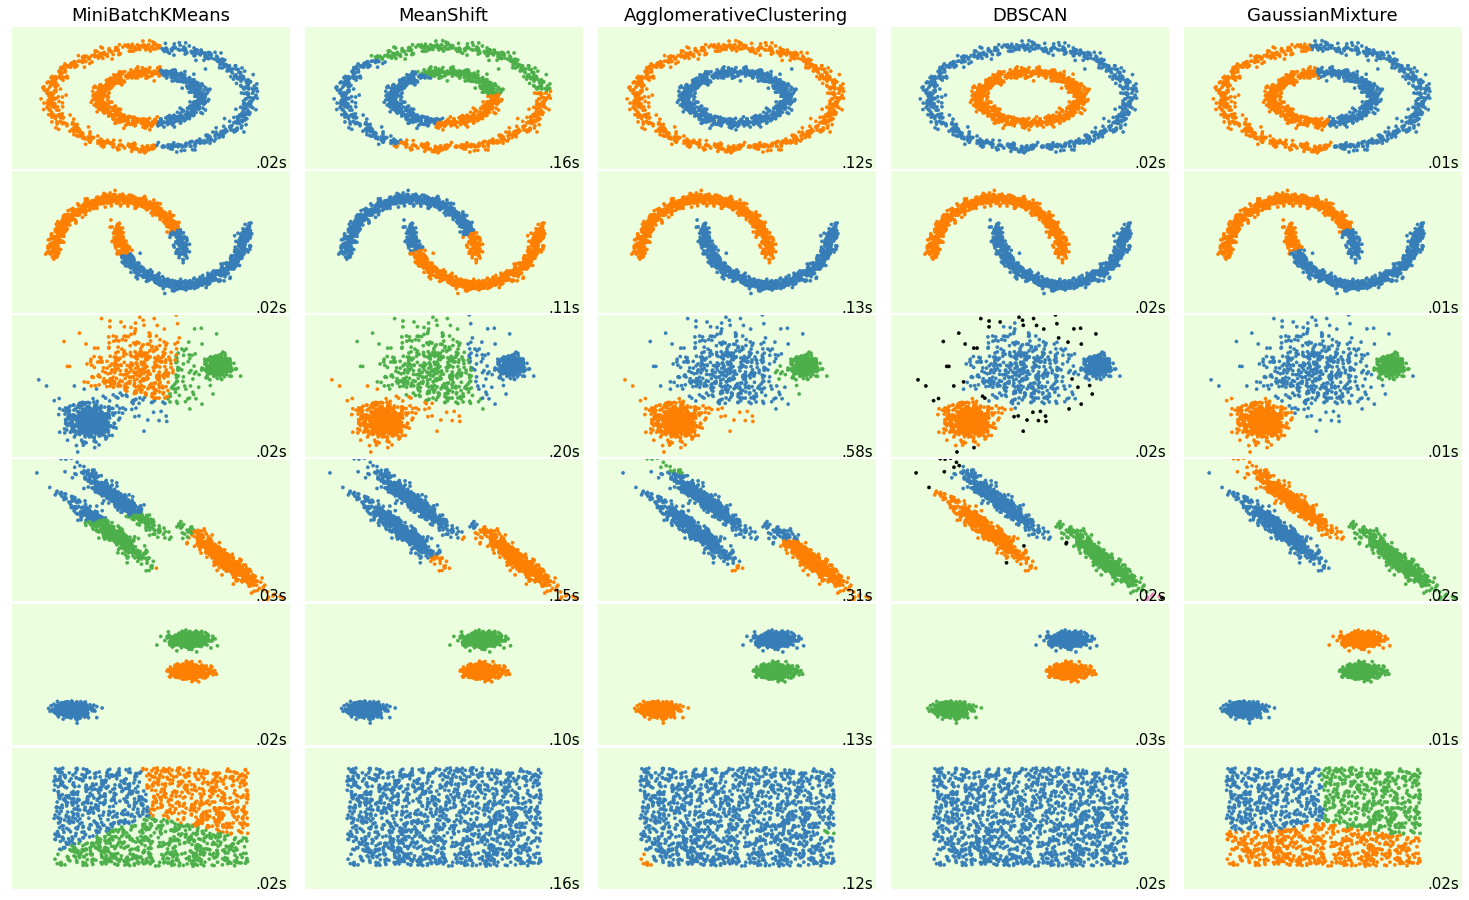

In [9]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['axes.facecolor'] = '#ebffde'
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate different toy datasets. We choose the size big enough to see the 
# scalability of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]


# loop su i 6 datasets
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

# Algoritmi di clustering per il confronto
    clustering_algorithms = (
        # k-means (con mini-batch)
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        #('SpectralClustering', spectral),
        #('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        #('OPTICS', optics),
        #('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### Analisi risultati: ###

* DBSCAN tipicamente funziona meglio degli altri algoritmi dal punto di vista dell'accuracy nelle predizioni ma fallisce nel terzo dataset

> NOTA: gli algoritmi basati sulla densità dei punti, quindi basati su informazioni locali, funzionano bene con dataset in cui i punti di una stessa classe sono connessi tra loto (dataset topologici), come quelli della righe 1,2, mentre possono avere problemi con dataset con grandi fluttuazioni nelle distribuzioni di densità del dataset *terza riga), e scalano male con alta dimensionalità delle feature

* gli algoritmi basati su metriche di distanza (tipo k-means) invece funzionano male su i primi due dataset e ovviamente quando il numero di cluster impostato è lontano dal valore vero (ultima distribuzione).


### Parte 2: Applicazione ad un dataset reale e analisi dei risultati con l'algoritmo k-means ###

Dataset: World Happiness Report 2016

The World Happiness Report is a landmark survey of the state of global happiness.

The happiness scores and rankings use data from the Gallup World Poll. The scores are based on answers to the main life evaluation question asked in the poll.

The columns following the happiness score estimate the extent to which each of six factors – economic production, social support, life expectancy, freedom, absence of corruption, and generosity – contribute to making life evaluations higher in each country than they are in Dystopia, a hypothetical country that has values equal to the world’s lowest national averages for each of the six factors. They have no impact on the total score reported for each country, but they do explain why some countries rank higher than others.

In [3]:
#leggiamo il dataset con pandas

import numpy as np
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/2016.csv')
data

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Benin,Sub-Saharan Africa,153,3.484,3.404,3.564,0.39499,0.10419,0.21028,0.39747,0.06681,0.20180,2.10812
153,Afghanistan,Southern Asia,154,3.360,3.288,3.432,0.38227,0.11037,0.17344,0.16430,0.07112,0.31268,2.14558
154,Togo,Sub-Saharan Africa,155,3.303,3.192,3.414,0.28123,0.00000,0.24811,0.34678,0.11587,0.17517,2.13540
155,Syria,Middle East and Northern Africa,156,3.069,2.936,3.202,0.74719,0.14866,0.62994,0.06912,0.17233,0.48397,0.81789


In [0]:
# controllo sul contenuto

#lista delle feature (per la selezione nel dataframe pandas)

sel_features = ['Economy (GDP per Capita)','Family','Health (Life Expectancy)','Freedom','Trust (Government Corruption)','Generosity','Dystopia Residual']

In [5]:
# summary statistic del dataset

data[sel_features].describe()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.953880,0.793621,0.557619,0.370994,0.137624,0.242635,2.325807
std,0.412595,0.266706,0.229349,0.145507,0.111038,0.133756,0.542220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.817890
25%,0.670240,0.641840,0.382910,0.257480,0.061260,0.154570,2.031710
50%,1.027800,0.841420,0.596590,0.397470,0.105470,0.222450,2.290740
75%,1.279640,1.021520,0.729930,0.484530,0.175540,0.311850,2.664650
max,1.824270,1.183260,0.952770,0.608480,0.505210,0.819710,3.837720


In [0]:
# controllo sulla correlazione dei dati

data[sel_features].corr()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Economy (GDP per Capita),1.000000,0.669540,0.837067,0.362283,0.294185,-0.025531,0.068624
Family,0.669540,1.000000,0.588377,0.450208,0.213561,0.089629,0.119672
Health (Life Expectancy),0.837067,0.588377,1.000000,0.341199,0.249583,0.075987,0.100857
Freedom,0.362283,0.450208,0.341199,1.000000,0.502054,0.361751,0.091631
Trust (Government Corruption),0.294185,0.213561,0.249583,0.502054,1.000000,0.305930,-0.002909
Generosity,-0.025531,0.089629,0.075987,0.361751,0.305930,1.000000,-0.133001
Dystopia Residual,0.068624,0.119672,0.100857,0.091631,-0.002909,-0.133001,1.000000


alcune feature mostrano una certa correlazione ...

In [0]:
# visualizzazione con t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# sklearn tSNE con pre-pca applicata 
# typical value for perplexity between 5 and 50 (should be tested)
tsne = TSNE(n_components=2, init='pca', perplexity = 10)
tsne_data = tsne.fit_transform(data[sel_features])

In [12]:
# salviamo i risultati nel dataframe

data['tsne-one'] = tsne_data[:,0]
data['tsne-two'] = tsne_data[:,1]
data

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,pca-one,pca-two,tsne-one,tsne-two
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,-0.668003,-0.448549,0.818631,-41.273136
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,-0.665716,-0.544311,-1.366023,-41.301208
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,-0.751940,-0.412911,-5.991512,-38.532486
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,-0.636200,-0.563237,-0.687390,-39.445026
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,-0.732819,-0.374170,0.011341,-43.163250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Benin,Sub-Saharan Africa,153,3.484,3.404,3.564,0.39499,0.10419,0.21028,0.39747,0.06681,0.20180,2.10812,0.578758,0.696299,16.020624,33.490944
153,Afghanistan,Southern Asia,154,3.360,3.288,3.432,0.38227,0.11037,0.17344,0.16430,0.07112,0.31268,2.14558,0.572888,0.754763,16.703823,31.446390
154,Togo,Sub-Saharan Africa,155,3.303,3.192,3.414,0.28123,0.00000,0.24811,0.34678,0.11587,0.17517,2.13540,0.607072,0.818806,17.603022,33.462196
155,Syria,Middle East and Northern Africa,156,3.069,2.936,3.202,0.74719,0.14866,0.62994,0.06912,0.17233,0.48397,0.81789,1.571483,-0.259017,-21.396935,19.847120


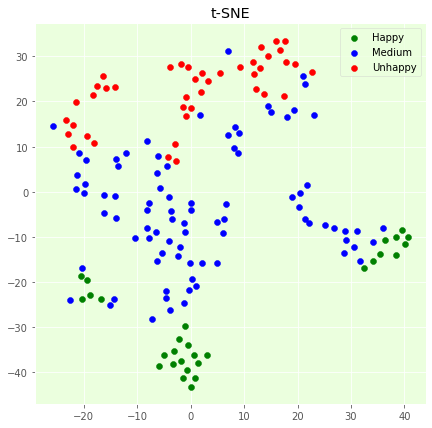

In [13]:
#plot dei risultati
plt.figure(figsize=(7,7))

happy = data.loc[data['Happiness Score']>=6.5]
medium = data.loc[(data['Happiness Score']>4.5) & (data['Happiness Score']<6.5)]
unhappy = data.loc[data['Happiness Score']<=4.5]

plt.scatter(happy['tsne-one'], happy['tsne-two'], c='green', label='Happy')
plt.scatter(medium['tsne-one'], medium['tsne-two'], c='blue', label='Medium')
plt.scatter(unhappy['tsne-one'], unhappy['tsne-two'], c='red', label='Unhappy')
plt.legend()
plt.title('t-SNE');

si notano due gruppi distinti di paesi felici ... andiamo a controllare

In [0]:
happy.loc[data['tsne-one']>10]

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,tsne-one,tsne-two
10,Israel,Middle East and Northern Africa,11,7.267,7.199,7.335,1.33766,0.99537,0.84917,0.36432,0.08728,0.32288,3.31029,38.378937,-14.061131
13,Costa Rica,Latin America and Caribbean,14,7.087,6.999,7.175,1.06879,1.02152,0.76146,0.55225,0.10547,0.22553,3.35168,35.477821,-13.763563
14,Puerto Rico,Latin America and Caribbean,15,7.039,6.794,7.284,1.35943,1.08113,0.77758,0.46823,0.12275,0.22202,3.00760,40.067146,-11.575621
16,Brazil,Latin America and Caribbean,17,6.952,6.875,7.029,1.08754,1.03938,0.61415,0.40425,0.14166,0.15776,3.50733,34.105885,-15.301084
20,Mexico,Latin America and Caribbean,21,6.778,6.680,6.876,1.11508,0.71460,0.71143,0.37709,0.18355,0.11735,3.55906,32.480446,-16.993153
23,Chile,Latin America and Caribbean,24,6.705,6.615,6.795,1.21670,0.90587,0.81883,0.37789,0.11451,0.31595,2.95505,39.464314,-8.413197
24,Panama,Latin America and Caribbean,25,6.701,6.601,6.801,1.18306,0.98912,0.70835,0.48927,0.08423,0.24180,3.00559,38.414921,-10.049417
25,Argentina,Latin America and Caribbean,26,6.650,6.560,6.740,1.15137,1.06612,0.69711,0.42284,0.07296,0.10989,3.12985,36.271248,-10.698177
26,Czech Republic,Central and Eastern Europe,27,6.596,6.515,6.677,1.30915,1.00793,0.76376,0.41418,0.03986,0.09929,2.96211,40.672615,-10.071486


In [0]:
happy.loc[data['tsne-one']<10]

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,tsne-one,tsne-two
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,0.818631,-41.273136
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,-1.366023,-41.301208
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,-5.991512,-38.532486
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,-0.687390,-39.445026
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,0.011341,-43.163250
5,Canada,North America,6,7.404,7.335,7.473,1.44015,1.09610,0.82760,0.57370,0.31329,0.44834,2.70485,-1.786754,-37.532829
6,Netherlands,Western Europe,7,7.339,7.284,7.394,1.46468,1.02912,0.81231,0.55211,0.29927,0.47416,2.70749,-3.260576,-38.198681
7,New Zealand,Australia and New Zealand,8,7.334,7.264,7.404,1.36066,1.17278,0.83096,0.58147,0.41904,0.49401,2.47553,2.980772,-36.246441
8,Australia,Australia and New Zealand,9,7.313,7.241,7.385,1.44443,1.10476,0.85120,0.56837,0.32331,0.47407,2.54650,0.660523,-36.281292
9,Sweden,Western Europe,10,7.291,7.227,7.355,1.45181,1.08764,0.83121,0.58218,0.40867,0.38254,2.54734,1.458367,-37.954338


In [7]:
# Visualizzazione con PCA

from sklearn.decomposition import PCA

#consideriamo solo le prime tre componenti
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data[sel_features].values)

data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1] 

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#NOTA: l'explained variation indica quanto ciascuna componente contribusice alla varianza totale del campione

Explained variation per principal component: [0.47971059 0.37710712 0.0571725 ]


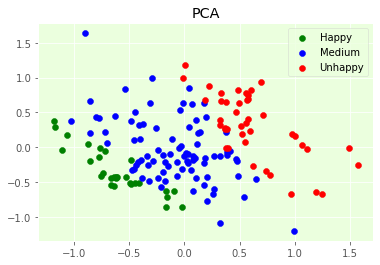

In [14]:
happy = data.loc[data['Happiness Score']>=6.5]
medium = data.loc[(data['Happiness Score']>4.5) & (data['Happiness Score']<6.5)]
unhappy = data.loc[data['Happiness Score']<=4.5]

plt.scatter(happy['pca-one'], happy['pca-two'], c='green', label='Happy')
plt.scatter(medium['pca-one'], medium['pca-two'], c='blue', label='Medium')
plt.scatter(unhappy['pca-one'], unhappy['pca-two'], c='red', label='Unhappy')
plt.legend()
plt.title('PCA');

In [0]:
#Clustering using k-means

from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=20, max_iter=600, 
    tol=1e-04, random_state=0
)
y_km = km.fit(data[sel_features].values)
y_pred = y_km.labels_.astype(np.int)

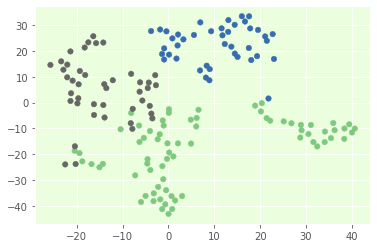

In [27]:
#confronto con tSNE
ax = plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=y_pred, cmap='Accent')

Proviamo a scegliere k andando ad analizzare se i dati indicano qualche preferenza specifica, questo può essere fatto sia guardando alla **distortion** (metodo dell'elbow): *somma delle distanze quadratiche dei campioni dai centri dei cluster più vicini*. 

Ci aspettiamo che la distortion subisca un cambio di pendenza una volta raggiunto il k ottimale ...

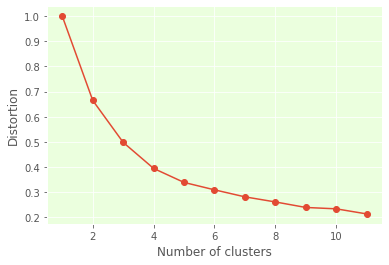

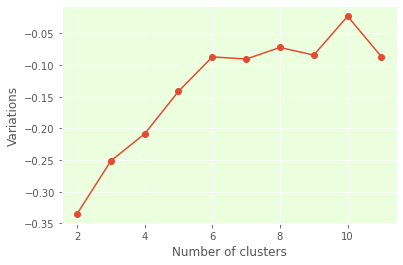

In [28]:
# calcoliamo il best k usando la distorsione
# NOTA: distorsione: Sum of squared distances of samples to their closest cluster center
k_max=12
distortions = []
variations = []
old = 0
for i in range(1, k_max):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=20, max_iter=600,
        tol=1e-04, random_state=0
    )
    km.fit(data[sel_features].values)
    
    distortions.append(km.inertia_)
    if (i>1):
       variations.append((km.inertia_-old)/old)
    old = km.inertia_

# plot
plt.plot(range(1, k_max), distortions/distortions[0], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
plt.plot(range(2, k_max), variations, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Variations')
plt.show()

indicazione di un k tra 4 e 6.

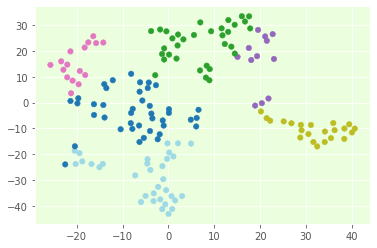

In [29]:
#Clustering using k-means

from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=6, init='k-means++',
    n_init=20, max_iter=600, 
    tol=1e-04, random_state=0
)
y_km = km.fit(data[sel_features].values)
y_pred = y_km.labels_.astype(np.int)

ax = plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=y_pred, cmap='tab20')


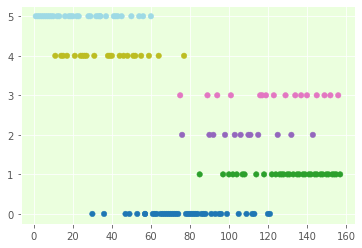

In [30]:
ax = plt.scatter(data['Happiness Rank'],y_pred, s=30, c=y_pred, cmap='tab20')

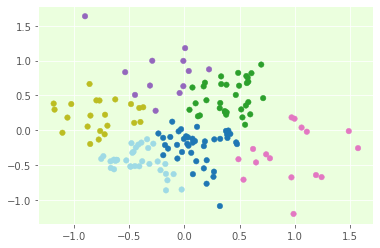

In [31]:
ax = plt.scatter(data['pca-one'],data['pca-two'], s=30, c=y_pred, cmap='tab20')

### Esercizi: ###

* testare i vari algoritmi di clustering in funzione dei loro parametri

* indentificare quali tra le feature del World Happines report dataset forniscono i maggior contributo all'Happines Rank: i.e. cosa rende un paese felice?

#### Clustering con Gaussian Mixture ####

Testiamo la resa di un modello Gaussian Mixture sul dataset appena analizzato. Selezioniamo il numero di componenti (da 3 a 10) tramite il *Bayesian Informarion Criterion*, minimizzando: <br>
$ \displaystyle \mathrm {BIC} =\ln(n)k-2\ln({\widehat {L}}).\ $ <br>
dove $n$ è il numero dei samples, $k$ il numero dei parametri stimati per un determinato modello e ${\widehat {L}}$ la likelihood del singolo modello una volta massimizzata. <br>
Tale criterio è implementato in `sklearn.mixture.GaussianMixture.bic`.

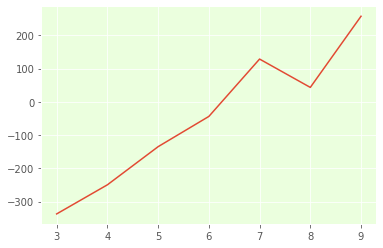

In [32]:
comps_list = np.arange(3, 10, 1)
bics = []
for comps in comps_list:
  gmm = mixture.GaussianMixture(n_components=comps)
  gmm.fit(data[sel_features])
  bics.append(gmm.bic(data[sel_features]))

plt.plot(comps_list, bics)

Il miglior numero di compomenti è quindi 3. <br>
Mostriamo quindi, utilizzando la tSNE, le predizioni del modello, confrontate con la ground truth, riferita alle tre classi *happy, medium, unhappy*.<br>Nel contempo procediamo a valutare l'accuracy di tale modello, se usato come classificatore tra le tre classi suddette.



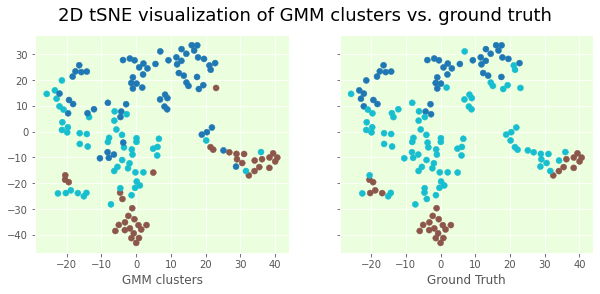



Accuracy: 0.6878980891719746


In [33]:
from scipy.stats import mode
gmm = mixture.GaussianMixture(n_components=3, random_state=11)
gmm.fit(data[sel_features])
N = len(data)
gmm_pred = gmm.predict(data[sel_features])

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].scatter(data['tsne-one'], data['tsne-two'], c=gmm_pred, cmap='tab10')
axs[0].set(xlabel="GMM clusters")
accuracy = 0

for df in [happy, unhappy, medium]:
  df_gmm_pred = gmm.predict(df[sel_features])
  col = mode(df_gmm_pred)[0]
  corrects = (df_gmm_pred == col)
  accuracy += np.sum(corrects)/N
  
  axs[1].scatter(df['tsne-one'], df['tsne-two'], c=[col]*len(df), cmap='tab10', vmin=0, vmax=2)
  axs[1].set(xlabel="Ground Truth")

# dato un indice di cluster C, 
# labels[C] restituisce 0, 1, 2 per happy, unhappy, medium
fig.suptitle("2D tSNE visualization of GMM clusters vs. ground truth", fontsize=18)
plt.show()
print(f"\n\nAccuracy: {accuracy}")

Gli output sono abbastanza simili e il risultato di accuracy ottenuto, vicino al 70%, risulta accettabile, soprattutto se rapportato alla evidente non-gaussianità dei dati. <br>


#### Features Selection ####

Abbiamo utilizzato due metodi differenti per identificare le più importanti. I risultati ottenuti sono estremamemente simili, e portano a pensare ad una reale, ma non sorprendente, prevalenza di due feature:
* Prodotto Interno Lordo
* Aspettativa di vita

Il primo metodo è la valutazione della correlazione lineare tra l'Happiness Rank e le features selezionate.

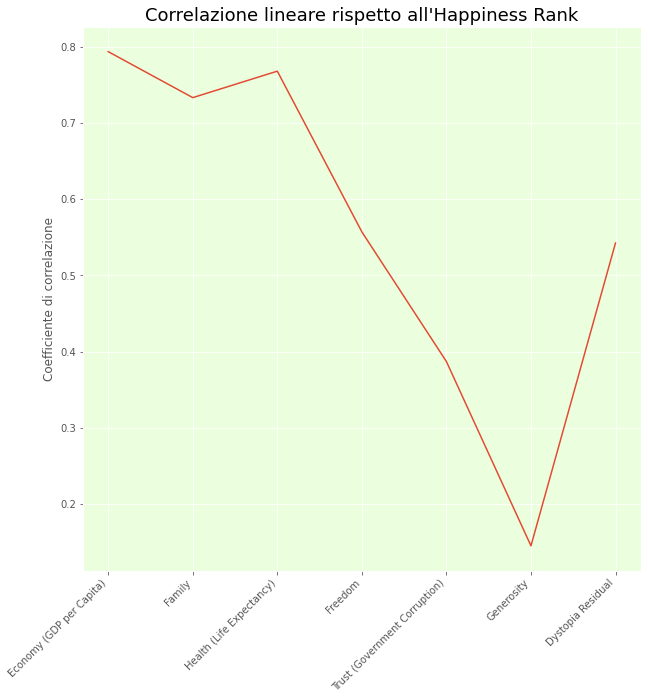

In [34]:
corr = data[sel_features].corrwith(data["Happiness Rank"])
plt.figure(figsize=(10,10))
plt.plot(- corr)
plt.xticks(rotation=45, ha="right")
plt.title("Correlazione lineare rispetto all'Happiness Rank", fontsize=18)
plt.ylabel("Coefficiente di correlazione")
plt.show()

Il secondo metodo è l'utilizzo di una Random Forest in modalità di regressione. Gli alberi decisionali, infatti, sono privilegiati rispetto a molti altri algoritmi di regressione, poiché consentono di stabilire facilmente quali feature sono le più utilizzate, considerando la diminuzione media di purity tra i nodi che utilizzano ogni singola feature. <br>
Come nel caso precedente, le feature considerate più importanti sono PIL e aspettativa di vita.

Train R^2: 0.9861103038214498
Test R^2: 0.9471869880928774


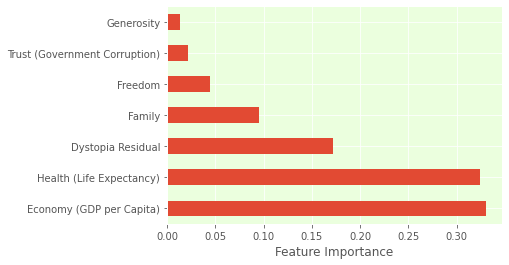

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

model = RandomForestRegressor()
x_train, x_test, y_train, y_test = train_test_split (
    data[sel_features], data["Happiness Rank"], 
    test_size=0.1
)
model.fit(x_train, y_train)
print(f"Train R^2: {model.score(x_train, y_train)}")
print(f"Test R^2: {model.score(x_test, y_test)}")
feat_importances = pd.Series(model.feature_importances_, index=data[sel_features].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.show()